In [ ]:
import gurobipy as gp
from gurobipy import GRB

model = gp.Model("Lower_Level_VPP")

# Time periods
T = [1, 2, 3, 4, 5]

# Time step
Δt = 1

# Electricity prices comes from the upper level
λ_EP = [0.4,0.8,1.4, 0.6,0.9]  # Electricity price in €/kWh
λ_ES = [0.5,1.2,0.34, 0.7,0.8]  # Electricity selling price in €/kWh

# Demand for each time period
# PD = [1, 2.2, 0.5, 1, 1.2] 
PD = {1:[1, 1.5,2,2.5,1], 2:[1, 2,2,2.5,4]}

# Cost coefficients
a1, b1, c1 = 1, 1, 1
e1, e2 = 0.5, 0.3

# Capacity limits
PVPP_p_max = 3
PVPP_s_max = 3
PMT_max = 5
PMT_down, PMT_up = 1, 1
PBS1_max = 2
PBS2_max = 2
E1_max = 0.2
E2_max = 0.2
SOC1_min, SOC1_max = 0.2, 1.0
SOC2_min, SOC2_max = 0.2, 0.98
SOC1_0 = 0.7
SOC2_0 = 0.7
PWT_max = 1

# Decision variables
PVPP_p = model.addVars(T, name="PVPP_p", lb=0, ub=PVPP_p_max)
PVPP_s = model.addVars(T, name="PVPP_s", lb=0, ub=PVPP_s_max)
PVPP = model.addVars(T, name="PVPP")
PMT = model.addVars(T, name="PMT", lb=0, ub=PMT_max)
PBS1 = model.addVars(T, name="PBS1", lb=-PBS1_max, ub=PBS1_max)
PBS2 = model.addVars(T, name="PBS2", lb=-PBS2_max, ub=PBS2_max)
SOC1 = model.addVars(T, name="SOC1", lb=SOC1_min, ub=SOC1_max) 
SOC2 = model.addVars(T, name="SOC2", lb=SOC2_min, ub=SOC2_max)
PWT = model.addVars(T, name="PWT", lb=0, ub=PWT_max)

# Objective function
model.setObjective(
    gp.quicksum(λ_EP[t-1] * PVPP_p[t] - λ_ES[t-1] * PVPP_s[t] for t in T) +
    gp.quicksum(a1 * (PMT[t] * Δt)**2 + b1 * PMT[t] * Δt + c1 for t in T) +
    gp.quicksum(e1 * (PBS1[t] * Δt)**2 + e2 * (PBS2[t] * Δt)**2 for t in T),
    GRB.MINIMIZE
)

# Constraints
for t in T:
    # PVPP flow definition
    model.addConstr(PVPP[t] == PVPP_p[t] - PVPP_s[t], name=f"PVPP_flow_{t}")
    # Power balance
    model.addConstr(PVPP[t] + (PMT[t] + PBS1[t] + PBS2[t] + PWT[t]) * Δt == PD[t-1] * Δt, name=f"power_balance_{t}")

# Ramp rate constraints for MT1
model.addConstr(PMT[2] - PMT[1] <= PMT_up * Δt)
model.addConstr(PMT[2] - PMT[1] >= -PMT_down * Δt)
model.addConstr(PMT[3] - PMT[2] <= PMT_up * Δt)
model.addConstr(PMT[3] - PMT[2] >= -PMT_down * Δt)

# SOC updates for BS1
model.addConstr(SOC1[1] == SOC1_0 - (Δt / E1_max) * PBS1[1])
model.addConstr(SOC1[2] == SOC1[1] - (Δt / E1_max) * PBS1[2])
model.addConstr(SOC1[3] == SOC1[2] - (Δt / E1_max) * PBS1[3])
model.addConstr(SOC1[3] == SOC1_0)

# SOC updates for BS2
model.addConstr(SOC2[1] == SOC2_0 - (Δt / E2_max) * PBS2[1])
model.addConstr(SOC2[2] == SOC2[1] - (Δt / E2_max) * PBS2[2])
model.addConstr(SOC2[3] == SOC2[2] - (Δt / E2_max) * PBS2[3])
model.addConstr(SOC2[3] == SOC2_0)

# Solve the model
model.optimize()

# Display results
if model.status == GRB.OPTIMAL:
    print("\nOptimal Solution:")
    for var in model.getVars():
        print(f"{var.VarName}: {var.X}")
    print(f"Objective Value: {model.ObjVal}")
else:
    print("No optimal solution found.")


Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (win64 - Windows 10.0 (19045.2))

CPU model: 13th Gen Intel(R) Core(TM) i9-13900H, instruction set [SSE2|AVX|AVX2]
Thread count: 14 physical cores, 20 logical processors, using up to 20 threads

Optimize a model with 22 rows, 45 columns and 66 nonzeros
Model fingerprint: 0x0920d587
Model has 15 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 5e+00]
  Objective range  [3e-01, 1e+00]
  QObjective range [6e-01, 2e+00]
  Bounds range     [2e-01, 5e+00]
  RHS range        [7e-01, 3e+00]
Presolve removed 8 rows and 10 columns
Presolve time: 0.00s
Presolved: 14 rows, 37 columns, 52 nonzeros
Presolved model has 15 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 1.600e+01
 Factor NZ  : 6.100e+01
 Factor Ops : 3.950e+02 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl

In [43]:
PBS1, T

({1: <gurobi.Var PBS1[1] (value -0.0599999999954371)>,
  2: <gurobi.Var PBS1[2] (value 1.6295853555448048e-11)>,
  3: <gurobi.Var PBS1[3] (value 0.059999999979140975)>,
  4: <gurobi.Var PBS1[4] (value 0.5624999999889622)>,
  5: <gurobi.Var PBS1[5] (value 2.831924614987713e-05)>},
 [1, 2, 3, 4, 5])

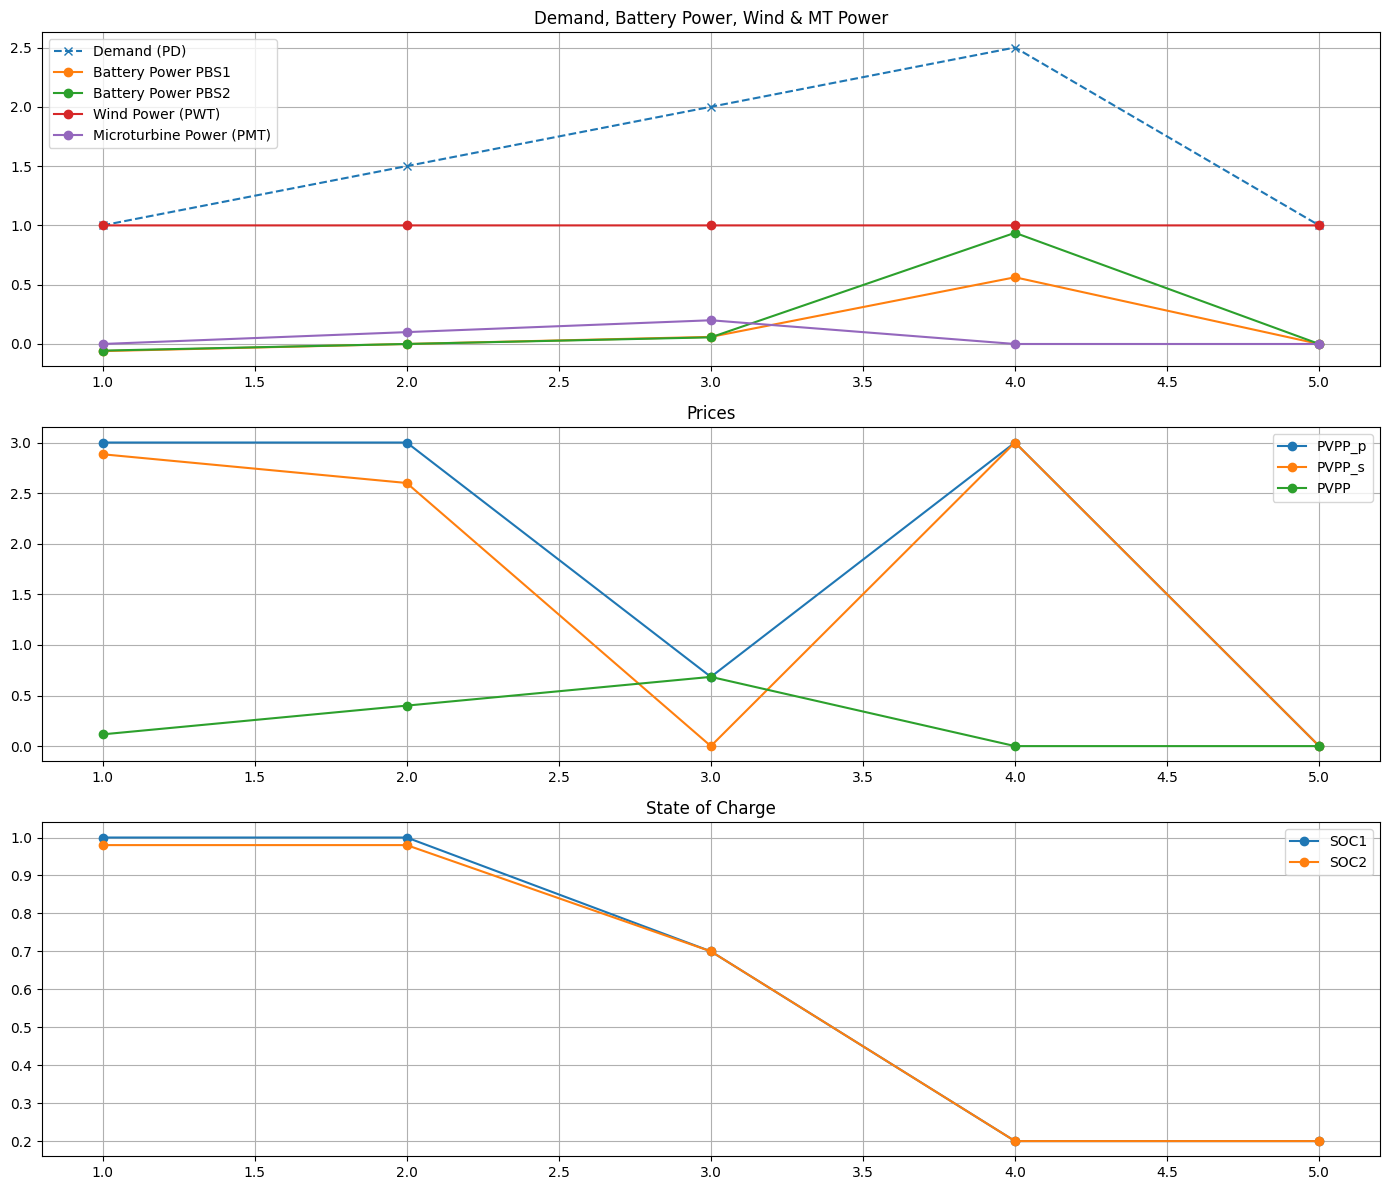

In [44]:
# Example extraction for Gurobi variables stored in dicts
from matplotlib import pyplot as plt
PBS1_values = [PBS1[i].X for i in T]
PBS2_values = [PBS2[i].X for i in T]
PMT_values  = [PMT[i].X for i in T]
PWT_values  = [PWT[i].X for i in T]

PVPP_p_values = [PVPP_p[i].X for i in T]
PVPP_s_values = [PVPP_s[i].X for i in T]
PVPP_values   = [PVPP[i].X for i in T]

SOC1_values = [SOC1[i].X for i in T]
SOC2_values = [SOC2[i].X for i in T]

# Now plot as usual
fig, axs = plt.subplots(3, 1, figsize=(14, 12))

# Top Plot: Demand, Battery Power, Wind, MT
axs[0].plot(T, PD, marker='x', linestyle='--', label='Demand (PD)')
axs[0].plot(T, PBS1_values, marker='o', label='Battery Power PBS1')
axs[0].plot(T, PBS2_values, marker='o', label='Battery Power PBS2')
axs[0].plot(T, PWT_values, marker='o', label='Wind Power (PWT)')
axs[0].plot(T, PMT_values, marker='o', label='Microturbine Power (PMT)')
axs[0].set_title('Demand, Battery Power, Wind & MT Power')
axs[0].legend()
axs[0].grid(True)

# Middle Plot: Prices
axs[1].plot(T, PVPP_p_values, marker='o', label='PVPP_p')
axs[1].plot(T, PVPP_s_values, marker='o', label='PVPP_s')
axs[1].plot(T, PVPP_values, marker='o', label='PVPP')
axs[1].set_title('Prices')
axs[1].legend()
axs[1].grid(True)

# Bottom Plot: State of Charge
axs[2].plot(T, SOC1_values, marker='o', label='SOC1')
axs[2].plot(T, SOC2_values, marker='o', label='SOC2')
axs[2].set_title('State of Charge')
axs[2].legend()
axs[2].grid(True)

plt.tight_layout()
plt.show()


In [37]:
model.write("VPP_lower_Level_Test.lp")  # Save the model to a file

B&B on to of McCormick relaxation

In [14]:
import pulp

# Given data
x_hat = [0, 1, 0, 1/6, 4/5, 1/2]
weights = [12, 8, 7, 6, 5, 2]
rhs = 15

# Initialize the problem
prob = pulp.LpProblem("Knapsack_Cover_Separation", pulp.LpMinimize)

# Define binary variables y1 to y6
y = [pulp.LpVariable(f'y{i+1}', cat='Binary') for i in range(6)]

# Objective function: Minimize sum (1 - x_hat[i]) * y[i]
objective = pulp.lpSum([(1 - x_hat[i]) * y[i] for i in range(6)])
prob += objective

# Constraint: weighted sum >= 15
prob += pulp.lpSum([weights[i] * y[i] for i in range(6)]) >= rhs

# Solve the problem
prob.solve()

# Get results
status = pulp.LpStatus[prob.status]
objective_value = pulp.value(prob.objective)
y_values = [int(y[i].varValue) for i in range(6)]

status, objective_value, y_values


('Optimal', 0.7, [0, 1, 0, 0, 1, 1])

Generalized UL

In [ ]:
import gurobipy as gp
from gurobipy import GRB

model = gp.Model("Lower_Level_Multi_VPP")

# Time and VPP sets
T = [1, 2, 3]
J = [1, 2, 3]  # Multiple VPPs with independent configs

Δt = 1

# Prices (same for all for now) - these would be from the upper level
λ_EP = {t: 0.8 for t in T}
λ_ES = {t: 0.34 for t in T}

# Demand per time period (split equally among VPPs)
PD_total = {1: 5.3, 2: 2.2, 3: 8}
PD = {j: {t: PD_total[t] / len(J) for t in T} for j in J}

# Per-VPP specific parameters
params = {
    1: {"PVPP_p_max": 3, "PVPP_s_max": 2, "PMT_max": 5, "PBS1_max": 1, "PBS2_max": 1, "E1_max": 2, "E2_max": 2, "SOC1_0": 0.5, "SOC2_0": 0.5, "SOC1_min": 0.2, "SOC1_max": 1.0, "SOC2_min": 0.2, "SOC2_max": 0.98},
    2: {"PVPP_p_max": 2.5, "PVPP_s_max": 3, "PMT_max": 4, "PBS1_max": 1.5, "PBS2_max": 1.5, "E1_max": 3, "E2_max": 3, "SOC1_0": 0.6, "SOC2_0": 0.6, "SOC1_min": 0.3, "SOC1_max": 1.1, "SOC2_min": 0.3, "SOC2_max": 1.0},
    3: {"PVPP_p_max": 4, "PVPP_s_max": 2.5, "PMT_max": 6, "PBS1_max": 2, "PBS2_max": 2, "E1_max": 2.5, "E2_max": 3.5, "SOC1_0": 0.4, "SOC2_0": 0.4, "SOC1_min": 0.2, "SOC1_max": 0.95, "SOC2_min": 0.2, "SOC2_max": 0.9}
}

PMT_down, PMT_up = 1, 1

a1, b1, c1 = 1, 1, 1
e1, e2 = 0.5, 0.3

# Decision variables
PVPP_p = {}
PVPP_s = {}
PVPP = {}
PMT = {}
PBS1 = {}
PBS2 = {}
SOC1 = {}
SOC2 = {}
PWT = {}

for j in J:
    for t in T:
        PVPP_p[j, t] = model.addVar(lb=0, ub=params[j]["PVPP_p_max"], name=f"PVPP_p_{j}_{t}")
        PVPP_s[j, t] = model.addVar(lb=0, ub=params[j]["PVPP_s_max"], name=f"PVPP_s_{j}_{t}")
        PVPP[j, t] = model.addVar(name=f"PVPP_{j}_{t}")
        PMT[j, t] = model.addVar(lb=0, ub=params[j]["PMT_max"], name=f"PMT_{j}_{t}")
        PBS1[j, t] = model.addVar(lb=-params[j]["PBS1_max"], ub=params[j]["PBS1_max"], name=f"PBS1_{j}_{t}")
        PBS2[j, t] = model.addVar(lb=-params[j]["PBS2_max"], ub=params[j]["PBS2_max"], name=f"PBS2_{j}_{t}")
        SOC1[j, t] = model.addVar(lb=params[j]["SOC1_min"], ub=params[j]["SOC1_max"], name=f"SOC1_{j}_{t}")
        SOC2[j, t] = model.addVar(lb=params[j]["SOC2_min"], ub=params[j]["SOC2_max"], name=f"SOC2_{j}_{t}")
        PWT[j, t] = model.addVar(lb=0, ub=1.5, name=f"PWT_{j}_{t}")

# Objective
model.setObjective(
    gp.quicksum(
        λ_EP[t] * PVPP_p[j, t] - λ_ES[t] * PVPP_s[j, t] +
        a1 * (PMT[j, t] * Δt)**2 + b1 * PMT[j, t] * Δt + c1 +
        e1 * (PBS1[j, t] * Δt)**2 + e2 * (PBS2[j, t] * Δt)**2
        for j in J for t in T
    ),
    GRB.MINIMIZE
)

# Constraints
for j in J:
    for t in T:
        model.addConstr(PVPP[j, t] == PVPP_p[j, t] - PVPP_s[j, t], name=f"PVPP_flow_{j}_{t}")
        model.addConstr(PVPP[j, t] + (PMT[j, t] + PBS1[j, t] + PBS2[j, t] + PWT[j, t]) * Δt == PD[j][t] * Δt, name=f"power_balance_{j}_{t}")

    model.addConstr(PMT[j, 2] - PMT[j, 1] <= PMT_up * Δt)
    model.addConstr(PMT[j, 2] - PMT[j, 1] >= -PMT_down * Δt)
    model.addConstr(PMT[j, 3] - PMT[j, 2] <= PMT_up * Δt)
    model.addConstr(PMT[j, 3] - PMT[j, 2] >= -PMT_down * Δt)

    model.addConstr(SOC1[j, 1] == params[j]["SOC1_0"] - (Δt / params[j]["E1_max"]) * PBS1[j, 1])
    model.addConstr(SOC1[j, 2] == SOC1[j, 1] - (Δt / params[j]["E1_max"]) * PBS1[j, 2])
    model.addConstr(SOC1[j, 3] == SOC1[j, 2] - (Δt / params[j]["E1_max"]) * PBS1[j, 3])
    model.addConstr(SOC1[j, 3] == params[j]["SOC1_0"])

    model.addConstr(SOC2[j, 1] == params[j]["SOC2_0"] - (Δt / params[j]["E2_max"]) * PBS2[j, 1])
    model.addConstr(SOC2[j, 2] == SOC2[j, 1] - (Δt / params[j]["E2_max"]) * PBS2[j, 2])
    model.addConstr(SOC2[j, 3] == SOC2[j, 2] - (Δt / params[j]["E2_max"]) * PBS2[j, 3])
    model.addConstr(SOC2[j, 3] == params[j]["SOC2_0"])

# Solve
model.optimize()

# Output
if model.status == GRB.OPTIMAL:
    for var in model.getVars():
        print(f"{var.VarName}: {var.X}")
    print(f"Objective Value: {model.ObjVal}")
else:
    print("No optimal solution found.")


Set parameter Username
Set parameter LicenseID to value 2644336
Academic license - for non-commercial use only - expires 2026-03-31
Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (win64 - Windows 10.0 (19045.2))

CPU model: 13th Gen Intel(R) Core(TM) i9-13900H, instruction set [SSE2|AVX|AVX2]
Thread count: 14 physical cores, 20 logical processors, using up to 20 threads

Optimize a model with 54 rows, 81 columns and 150 nonzeros
Model fingerprint: 0xe518b90a
Model has 27 quadratic objective terms
Coefficient statistics:
  Matrix range     [3e-01, 1e+00]
  Objective range  [3e-01, 1e+00]
  QObjective range [6e-01, 2e+00]
  Bounds range     [2e-01, 6e+00]
  RHS range        [4e-01, 3e+00]
Presolve removed 24 rows and 18 columns
Presolve time: 0.00s
Presolved: 30 rows, 69 columns, 108 nonzeros
Presolved model has 27 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 4.200e+01
 Factor NZ  : 1.650e+02
 Factor Ops : 1.155e+03 (less than 1 second per iteration